# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [2]:
# !mv kaggle.json /root/.kaggle/

In [3]:
# !chmod 600 /root/.kaggle/kaggle.json

In [4]:
# !kaggle competitions download -c journey-springfield

In [5]:
# !unzip -q /content/journey-springfield.zip -d simpsons/

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [6]:
import pickle
import numpy as np
from collections import defaultdict
import pandas as pd

from tqdm import tqdm
from PIL import Image
from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [8]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode, transform, label_encoder):
        super().__init__()
        self.label_encoder = label_encoder
        self.mode = mode
        self.transform = transform

        self.files = files
        if mode!='test':
            self.labels = [self.label_encoder.transform([path.parent.name]).item() for path in self.files]
        self.len_ = len(self.files)

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = np.array(x)
        # x = np.array(x / 255, dtype='float32')
        x = self.transform(image=x)['image']
        if self.mode == 'test':
            return x
        else:
            y = self.labels[index]
            return x, y

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('simpsons/train/simpsons_dataset')
TEST_DIR = Path('simpsons/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
train_val_labels = [path.parent.name for path in train_val_files]

In [12]:
len(train_val_files), len(test_files)

(20933, 991)

In [13]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.15, \
                                          stratify=train_val_labels)

In [14]:
global_label_encoder = LabelEncoder()
global_label_encoder.fit(train_val_labels)

LabelEncoder()

In [15]:
# для преобразования изображений в тензоры PyTorch и нормализации входа
# generic_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
# ])

In [16]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

albumentations_train_transform = A.Compose([
    A.Resize(256, 256), 
    A.RandomCrop(224, 224),
    A.HorizontalFlip(),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])


albumentations_test_transform = A.Compose([
    A.Resize(224, 224), 
    # A.CenterCrop(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])


In [17]:
# val_dataset = SimpsonsDataset(val_files, mode='val', transform=albumentations_test_transform, label_encoder=global_label_encoder)

Давайте посмотрим на наших героев внутри датасета.

In [18]:
# fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
#                         sharey=True, sharex=True)
# for fig_x in ax.flatten():
#     random_characters = int(np.random.uniform(0,1000))
#     im_val, label = val_dataset[random_characters]
#     img_label = " ".join(map(lambda x: x.capitalize(),\
#                 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
#     imshow(im_val.data.cpu(), \
#           title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    i = 0
    print('Started dataloader, i:', i, ' processed data:', processed_data)
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        i += 1
    print('Finished dataloader, i:', i, ' processed data:', processed_data)
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [20]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [21]:
def train(train_loader, val_loader, optimizer, scheduler, model, epochs):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            scheduler.step(val_loss)
            
    return history

In [22]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [23]:
from torchvision import models
n_classes = len(np.unique(train_val_labels))
simple_cnn = models.resnet18(pretrained=True)

# for layer in simple_cnn.parameters():
#     layer.requires_grad = False

/home/misha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/misha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
simple_cnn.fc = nn.Sequential(
    nn.Linear(512, 100),
    nn.ReLU(),
    nn.Linear(100, n_classes)
)
simple_cnn.fc.requires_grad = True
simple_cnn = simple_cnn.to(DEVICE)
print("we will classify :{}".format(n_classes))

we will classify :42


In [25]:
optimizer = torch.optim.SGD(simple_cnn.parameters(), lr=0.003, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

Запустим обучение сети.

In [26]:
val_dataset = SimpsonsDataset(val_files, mode='val', transform=albumentations_test_transform, label_encoder=global_label_encoder)

train_dataset = SimpsonsDataset(train_files, mode='train', transform=albumentations_train_transform, label_encoder=global_label_encoder)

In [27]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

def make_weights_for_balanced_classes(train_files, ds):
    target = [path.parent.name for path in train_files]
    target = torch.tensor([ds.label_encoder.transform([label]).item() for label in target])
    class_sample_count = torch.tensor(
        [(target == t).sum() for t in torch.unique(target, sorted=True)])
    weight = 1. / class_sample_count.float()
    samples_weight = torch.tensor([weight[t] for t in target])

    # print(train_labels)
    target = [path.parent.name for path in train_files]
    counter = Counter(target)
    # print(counter)
    return samples_weight, [1. / (counter[target[i]]) for i, train_val_file in enumerate(train_files)]

samples_weight, train_file_weights = make_weights_for_balanced_classes(train_files, train_dataset)
weighted_sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [28]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=weighted_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

<AxesSubplot:>

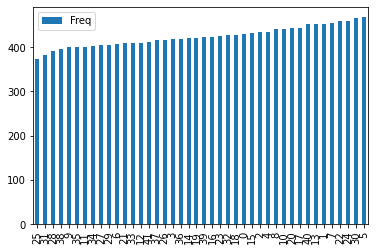

In [29]:
result = defaultdict(int)
for x, y in train_loader:
    counter = Counter(y.numpy())
    for k in counter:
        result[k]+=counter[k]

result_df = pd.DataFrame.from_dict(result, orient='index', columns=['Freq'])
result_df = result_df.sort_values('Freq')
result_df.plot(kind='bar')

In [30]:
history = train(train_loader, val_loader, optimizer, scheduler, model=simple_cnn, epochs=25)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 3.5488694608295264


epoch:   4%|▍         | 1/25 [00:33<13:19, 33.31s/it]


Epoch 001 train_loss: 3.5489     val_loss 3.4542 train_acc 0.1653 val_acc 0.2048
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 2.1329310395019103


epoch:   8%|▊         | 2/25 [01:04<12:19, 32.17s/it]


Epoch 002 train_loss: 2.1329     val_loss 0.8814 train_acc 0.5302 val_acc 0.7774
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.35151184220820664


epoch:  12%|█▏        | 3/25 [01:36<11:40, 31.83s/it]


Epoch 003 train_loss: 0.3515     val_loss 0.4634 train_acc 0.9073 val_acc 0.8790
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.18516816821989668


epoch:  16%|█▌        | 4/25 [02:07<11:05, 31.68s/it]


Epoch 004 train_loss: 0.1852     val_loss 0.3989 train_acc 0.9534 val_acc 0.8984
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.13048275185538832


epoch:  20%|██        | 5/25 [02:39<10:32, 31.61s/it]


Epoch 005 train_loss: 0.1305     val_loss 0.3469 train_acc 0.9676 val_acc 0.9140
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.09692684817615974


epoch:  24%|██▍       | 6/25 [03:10<10:00, 31.59s/it]


Epoch 006 train_loss: 0.0969     val_loss 0.3401 train_acc 0.9739 val_acc 0.9162
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.0825606032490784


epoch:  28%|██▊       | 7/25 [03:42<09:28, 31.57s/it]


Epoch 007 train_loss: 0.0826     val_loss 0.2933 train_acc 0.9794 val_acc 0.9242
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.06257898956614713


epoch:  32%|███▏      | 8/25 [04:13<08:56, 31.54s/it]


Epoch 008 train_loss: 0.0626     val_loss 0.2779 train_acc 0.9839 val_acc 0.9350
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.055025128312800445


epoch:  36%|███▌      | 9/25 [04:45<08:24, 31.52s/it]


Epoch 009 train_loss: 0.0550     val_loss 0.2495 train_acc 0.9861 val_acc 0.9411
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.0510398371814375


epoch:  40%|████      | 10/25 [05:16<07:52, 31.51s/it]


Epoch 010 train_loss: 0.0510     val_loss 0.2523 train_acc 0.9887 val_acc 0.9449
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.04880142829048086


epoch:  44%|████▍     | 11/25 [05:48<07:21, 31.50s/it]


Epoch 011 train_loss: 0.0488     val_loss 0.2789 train_acc 0.9867 val_acc 0.9338
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.041410927787378746


epoch:  48%|████▊     | 12/25 [06:19<06:49, 31.48s/it]


Epoch 012 train_loss: 0.0414     val_loss 0.2807 train_acc 0.9890 val_acc 0.9315
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.044094088577198445


epoch:  52%|█████▏    | 13/25 [06:50<06:17, 31.48s/it]


Epoch 013 train_loss: 0.0441     val_loss 0.2261 train_acc 0.9898 val_acc 0.9446
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.03253937753849412


epoch:  56%|█████▌    | 14/25 [07:22<05:46, 31.48s/it]


Epoch 014 train_loss: 0.0325     val_loss 0.2314 train_acc 0.9922 val_acc 0.9471
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.02939118310609817


epoch:  60%|██████    | 15/25 [07:53<05:14, 31.49s/it]


Epoch 015 train_loss: 0.0294     val_loss 0.2292 train_acc 0.9935 val_acc 0.9487
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.029334398887083234


epoch:  64%|██████▍   | 16/25 [08:25<04:43, 31.49s/it]


Epoch 016 train_loss: 0.0293     val_loss 0.2443 train_acc 0.9928 val_acc 0.9398
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.024591008035421795


epoch:  68%|██████▊   | 17/25 [08:56<04:11, 31.49s/it]


Epoch 017 train_loss: 0.0246     val_loss 0.2417 train_acc 0.9934 val_acc 0.9452
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.021431276306844122


epoch:  72%|███████▏  | 18/25 [09:28<03:40, 31.51s/it]


Epoch 018 train_loss: 0.0214     val_loss 0.2358 train_acc 0.9943 val_acc 0.9494
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.024691048334113206


epoch:  76%|███████▌  | 19/25 [09:59<03:09, 31.51s/it]


Epoch 019 train_loss: 0.0247     val_loss 0.2101 train_acc 0.9938 val_acc 0.9532
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.018733591261809582


epoch:  80%|████████  | 20/25 [10:31<02:37, 31.51s/it]


Epoch 020 train_loss: 0.0187     val_loss 0.2230 train_acc 0.9953 val_acc 0.9494
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.02000377687830192


epoch:  84%|████████▍ | 21/25 [11:02<02:06, 31.51s/it]


Epoch 021 train_loss: 0.0200     val_loss 0.2042 train_acc 0.9954 val_acc 0.9519
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.01685889680336747


epoch:  88%|████████▊ | 22/25 [11:34<01:34, 31.51s/it]


Epoch 022 train_loss: 0.0169     val_loss 0.2250 train_acc 0.9958 val_acc 0.9516
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.013183032369722875


epoch:  92%|█████████▏| 23/25 [12:06<01:03, 31.52s/it]


Epoch 023 train_loss: 0.0132     val_loss 0.1938 train_acc 0.9974 val_acc 0.9580
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.01700332722580199


epoch:  96%|█████████▌| 24/25 [12:37<00:31, 31.51s/it]


Epoch 024 train_loss: 0.0170     val_loss 0.2375 train_acc 0.9958 val_acc 0.9468
Started dataloader, i: 0  processed data: 0
Finished dataloader, i: 70  processed data: 17793
loss 0.015272137364917492


epoch: 100%|██████████| 25/25 [13:09<00:00, 31.56s/it]


Epoch 025 train_loss: 0.0153     val_loss 0.2395 train_acc 0.9959 val_acc 0.9525


Построим кривые обучения

In [46]:
loss, acc, val_loss, val_acc = zip(*history)


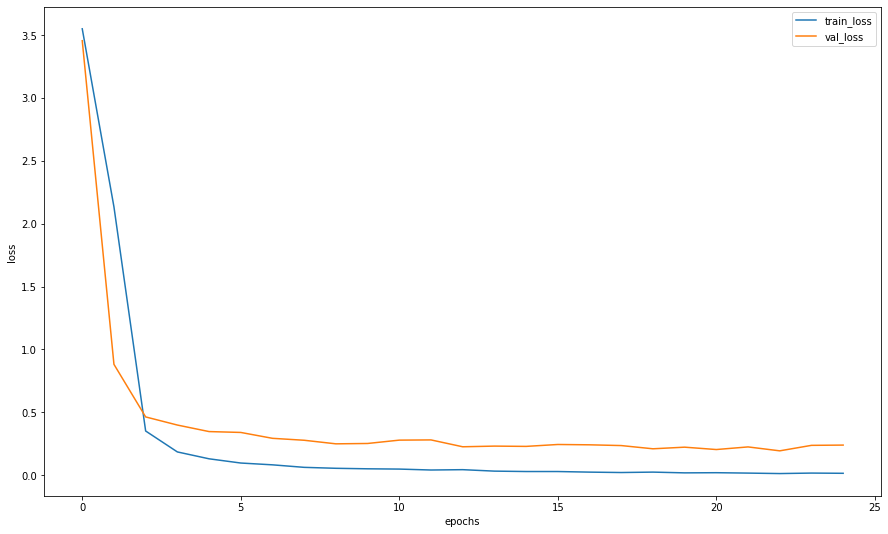

In [47]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [48]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [49]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [50]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [51]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [global_label_encoder.classes_[i] for i in y_pred]

In [52]:
actual_labels

[17, 0, 0, 15, 15, 9, 28, 41, 27, 28, 25, 15, 4, 25, 37, 25, 28, 32, 0, 6]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [53]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='macro')


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

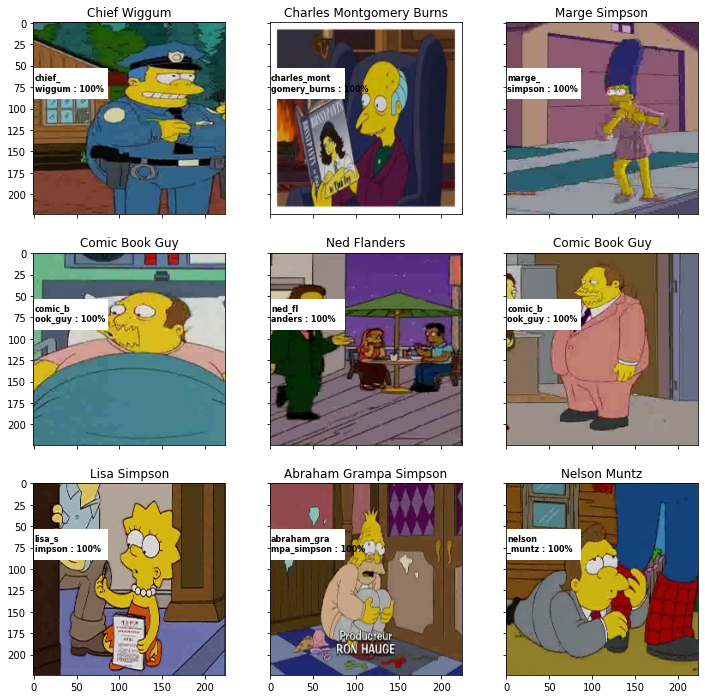

In [54]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = global_label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [55]:
test_dataset = SimpsonsDataset(test_files, mode="test", transform=albumentations_test_transform, label_encoder=global_label_encoder)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = global_label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [56]:
! ls 

Copy_of_simpsons_baseline.ipynb
journey-springfield.zip
label_encoder.pkl
resnet_152_adamw.csv
resnet_18_sgd_momentum.csv
resnet_18_sgd_unfreezed_balanced_25_epoch_2.csv
resnet_18_sgd_unfreezed_balanced_25_epoch.csv
resnet_18_sgd_unfreezed_momentum_20_epoch.csv
resnet_18_sgd_unfreezed_momentum.csv
resnet_34_sgd_unfreezed.csv
simpsons


In [57]:
import pandas as pd
# my_submit = pd.read_csv("simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [58]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [59]:
my_submit.to_csv('resnet_18_sgd_unfreezed_balanced_25_epoch_3.csv', index=False)

In [45]:
# !kaggle competitions submit -c journey-springfield -f resnet_18_sgd_unfreezed_momentum_20_epoch.csv -m "resnet 18 with sgd momentum unfreezed 20"
# !kaggle competitions submit -c journey-springfield -f resnet_34_sgd_unfreezed.csv -m "resnet 34 with sgd momentum unfreezed 20"

In [5]:
# !kaggle competitions submit -c journey-springfield -f resnet_18_sgd_unfreezed_balanced_25_epoch.csv -m "resnet 18 with sgd momentum unfreezed balanced 25"
# !kaggle competitions submit -c journey-springfield -f resnet_34_sgd_unfreezed_balanced_25_epoch.csv -m "resnet 34 with sgd momentum unfreezed balanced 25"

In [2]:
!kaggle competitions submit -c journey-springfield -f resnet_18_sgd_unfreezed_balanced_25_epoch_3.csv -m "resnet 18 with sgd momentum unfreezed balanced 25"

100%|██████████████████████████████████████| 25.8k/25.8k [00:01<00:00, 22.2kB/s]
Successfully submitted to Journey to Springfield

![alt text](score_kaggle.png "Title")

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
